In [1]:
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join
import os
from skimage.transform import resize, rescale
import matplotlib.pyplot as plt

In [2]:
def prep_im(im_id, im_dir_path = "", scalar = 1, output_shape = None):
    '''Prepare image from im_id and optional dictory path.
    If directory path is not passed, the whole filepath, including filetype notation, 
    should be given as im_id. If parameter scalar is passed, output image will be scaled by it. 
    Defualt 1 retains original size.
    
    Args:
        im_id (str): image ID
        im_dir_path (str, optional): image directory path
        scalar (float, optional): rescale coefficient

    Returns:
        im (numpy.ndarray): image.
    '''

    # Read and resize image
    if im_dir_path == "":
        im = plt.imread(im_id)[:, :, :3] #Some images have fourth, empty color chanel which we slice of here
    else:
        im = plt.imread(im_dir_path + im_id)[:, :, :3] #Some images have fourth, empty color chanel which we slice of here
    im = rescale(im, scalar, anti_aliasing=True, channel_axis = 2) #IDWE: Use channel_axis=2 to prevent picture from being turned bianry when rescaled
    if output_shape != None:
        im = resize(im, output_shape)

    return im

In [5]:
# Load images
image_folder_path = "test_images"
n_images = 100
paths = [f for f in listdir(image_folder_path) if isfile(join(image_folder_path, f))][:n_images]

images = []
for im_path in paths:
  image = prep_im(im_path, "test_images/", output_shape = (300,300))

  #image = Image.open(join(image_folder_path, im_path))
  #image = resize(image, (300,300)) # Make sure the image has the same size
  arr = np.asarray(image)
  images.append(arr)

FileNotFoundError: [Errno 2] No such file or directory: 'test_images/PAT_821_1547_77.png'

In [159]:
#Load labels for images
data = np.array([i.strip().split(',') for i in open('metadata.csv')])

mask = data == ''
data[np.where(mask)] = np.nan

labels = np.asarray([data[np.where(data[:,-2]==paths[i])[0][0],17] for i in range(len(paths))])

In [161]:
# Flatten it, now each row represents a single image
X = np.stack(images, axis = 0)

dim1, dim2, chan = arr.shape
n_features = chan*dim1*dim2
X = X.reshape((len(images), n_features)) # flattened --> this goes to PCA

print(np.shape(X))

(911, 270000)


In [197]:
# Init the model (a.k.a. specify the hyper-parameters e.g. number of components)
final_n_features = 100 # Hyper-parameter - try different values
pca = PCA(n_components=final_n_features)

In [198]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size= 0.2, random_state =1,stratify = labels)

In [199]:
# Transformed features
X_train_transformed = pca.fit_transform(X_train) # X_new has final_n_features --> this can be fed to the classfier model
X_train_recovered = pca.inverse_transform(X_train_transformed)

X_test_transformed = pca.fit_transform(X_test) # X_new has final_n_features --> this can be fed to the classfier model
X_test_recovered = pca.inverse_transform(X_test_transformed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


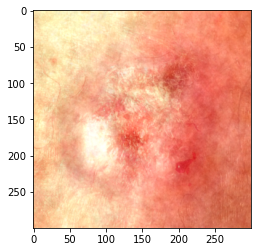

In [211]:
plt.imshow(X_train_recovered[10,:].reshape(300,300,3))

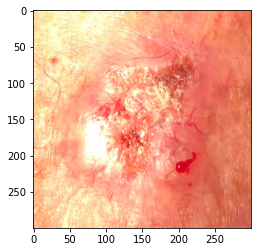

In [212]:
plt.imshow(X_train[10,:].reshape(300,300,3))

In [206]:
# Define a classifer
clf = KNeighborsClassifier(n_neighbors=10)

In [207]:
# Train it --> need to define y first
clf.fit(X_train_transformed, y_train)

KNeighborsClassifier(n_neighbors=10)

In [208]:
# TODO: Predict on validation dataset and measure accuracy, f1-score
clf.predict(X_test_transformed);

In [209]:
# Check accuracy of our model on the test data
clf.score(X_test_transformed, y_test)

0.5683060109289617

In [210]:
components = list(range(5,151,10))
neighbors = list(range(1,11))

In [196]:
for component in components:
    pca = PCA(n_components=component)
    
    X_train_transformed = pca.fit_transform(X_train) # X_new has final_n_features --> this can be fed to the classfier model
    X_train_recovered = pca.inverse_transform(X_train_transformed)

    X_test_transformed = pca.fit_transform(X_test) # X_new has final_n_features --> this can be fed to the classfier model
    X_test_recovered = pca.inverse_transform(X_test_transformed)
    
    for n in neighbors:
        clf = KNeighborsClassifier(n_neighbors=n)
        
        clf.fit(X_train_transformed, y_train)
        
        clf.predict(X_test_transformed)
        
        score = clf.score(X_test_transformed, y_test)
        
        print(f'Components: {component}, neighbors: {n}, Score: {score}')

Components: 5, neighbors: 1, Score: 0.3879781420765027
Components: 5, neighbors: 2, Score: 0.43169398907103823
Components: 5, neighbors: 3, Score: 0.4426229508196721
Components: 5, neighbors: 4, Score: 0.47540983606557374
Components: 5, neighbors: 5, Score: 0.5027322404371585
Components: 5, neighbors: 6, Score: 0.5136612021857924
Components: 5, neighbors: 7, Score: 0.5300546448087432
Components: 5, neighbors: 8, Score: 0.5409836065573771
Components: 5, neighbors: 9, Score: 0.5519125683060109
Components: 5, neighbors: 10, Score: 0.546448087431694
Components: 15, neighbors: 1, Score: 0.4262295081967213
Components: 15, neighbors: 2, Score: 0.41530054644808745
Components: 15, neighbors: 3, Score: 0.46994535519125685
Components: 15, neighbors: 4, Score: 0.4972677595628415
Components: 15, neighbors: 5, Score: 0.5245901639344263
Components: 15, neighbors: 6, Score: 0.5245901639344263
Components: 15, neighbors: 7, Score: 0.5355191256830601
Components: 15, neighbors: 8, Score: 0.546448087431694

Components: 145, neighbors: 10, Score: 0.5792349726775956
